In [1]:
import pandas as pd

file_path = 'detrend.nino34.ascii.txt'
# Read the file
data = pd.read_csv(file_path, delim_whitespace=True, header=None)
# Show the first few rows of the data
data.head()


,0,1,2,3,4
0,YR,MON,TOTAL,ClimAdjust,ANOM
1,1950,1,24.56,26.18,-1.62
2,1950,2,25.07,26.39,-1.32
3,1950,3,25.88,26.95,-1.07
4,1950,4,26.29,27.39,-1.11


In [2]:
# Define column names
column_names = ['Year', 'Month', 'Total', 'ClimAdjust', 'Anomaly']

# Re-read the data skipping the first row and assign column names
data = pd.read_csv(file_path, delim_whitespace=True, skiprows=1, names=column_names)

# Convert Year and Month to integers
data['Year'] = data['Year'].astype(int)
data['Month'] = data['Month'].astype(int)

# Convert other columns to float
data['Total'] = data['Total'].astype(float)
data['ClimAdjust'] = data['ClimAdjust'].astype(float)
data['Anomaly'] = data['Anomaly'].astype(float)

# Create a datetime index
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
data = data.set_index('Date')

# Show the first few rows of the processed data
data.head()


,Year,Month,Total,ClimAdjust,Anomaly
Date,,,,,
1950-01-01,1950,1,24.56,26.18,-1.62
1950-02-01,1950,2,25.07,26.39,-1.32
1950-03-01,1950,3,25.88,26.95,-1.07
1950-04-01,1950,4,26.29,27.39,-1.11
1950-05-01,1950,5,26.19,27.56,-1.37


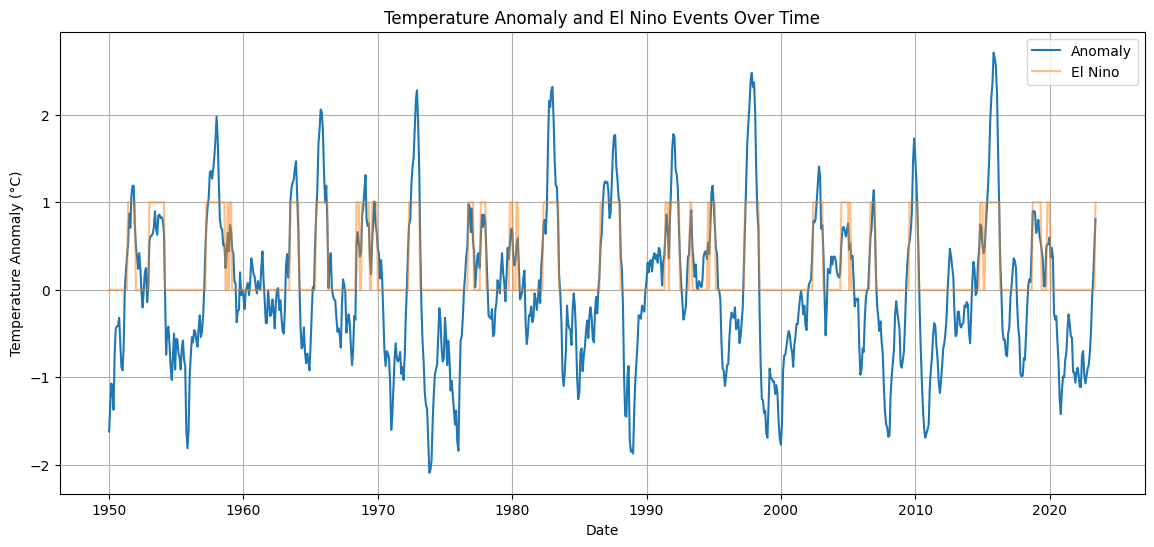

In [3]:
# Define the El Nino threshold
elnino_threshold = 0.5

# Create a binary column indicating El Nino events
data['ElNino'] = (data['Anomaly'] > elnino_threshold).astype(int)

# Import the necessary visualization libraries
import matplotlib.pyplot as plt

# Plot the Anomaly and El Nino indicator
plt.figure(figsize=(14,6))
plt.plot(data['Anomaly'], label='Anomaly')
plt.plot(data['ElNino'], label='El Nino', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Temperature Anomaly and El Nino Events Over Time')
plt.legend()
plt.grid(True)
plt.show()


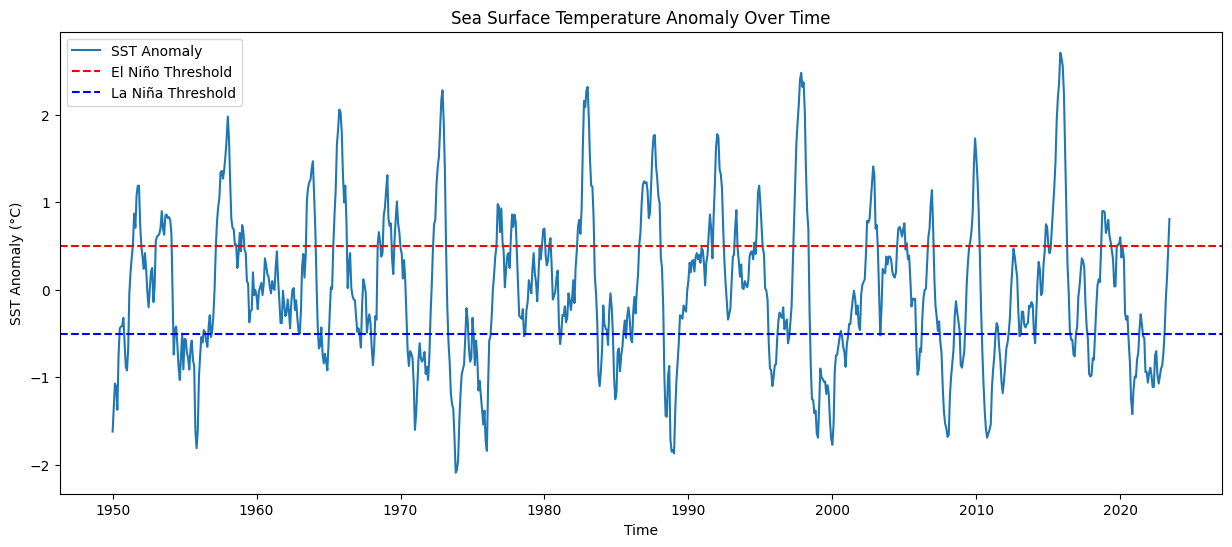

In [4]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Converting Year and Month to datetime format for easy plotting
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Plotting the anomaly over time
plt.figure(figsize=(15, 6))
plt.plot(data['Date'], data['Anomaly'], label='SST Anomaly')
plt.axhline(y=0.5, color='r', linestyle='--', label='El Niño Threshold')
plt.axhline(y=-0.5, color='b', linestyle='--', label='La Niña Threshold')
plt.title('Sea Surface Temperature Anomaly Over Time')
plt.xlabel('Time')
plt.ylabel('SST Anomaly (°C)')
plt.legend()
plt.show()


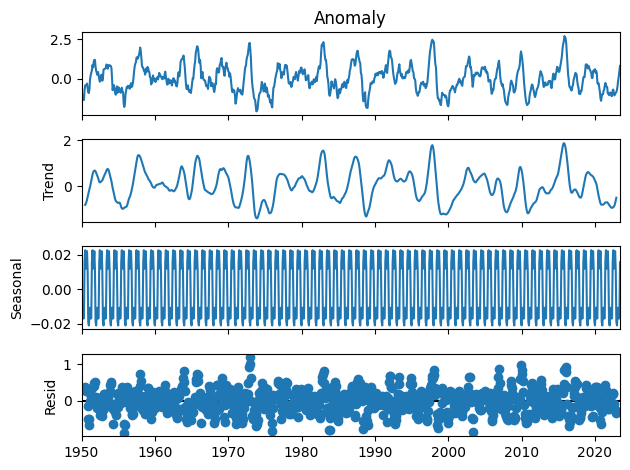

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to visualize trend, seasonality, and residuals
result = seasonal_decompose(data['Anomaly'], model='additive')
result.plot()
plt.show()

In [9]:
%%capture captured
# Added the above line to prevent excessive amounts of output due to the methods used

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, and q triplets (use 12 for the seasonal component)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Grid search to find the best parameters
min_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(data['Anomaly'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue


In [12]:
# Added print statement here as it would've been consumed by the %%capture command
print('Best SARIMA parameters:', best_pdq, best_seasonal_pdq)

Best SARIMA parameters: (1, 0, 1) (1, 0, 1, 12)


In [13]:
# Fit the SARIMA model with the best parameters
model = SARIMAX(data['Anomaly'], order=best_pdq, seasonal_order=best_seasonal_pdq, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Owner\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
# Create forecast object
forecast_object = model_fit.get_forecast(steps=12)

# Extract prediction and confidence intervals
mean_forecast_temps = forecast_object.predicted_mean
confidence_intervals = forecast_object.conf_int()

# Print forecast
print("Mean forecasted temperature difference for the next 12 months:")
print(mean_forecast_temps)

print("\nLower and upper temperature predictions (95% confidence):")
print(confidence_intervals)

Mean forecasted temperature difference for the next 12 months:
2023-07-01    0.891399
2023-08-01    0.883294
2023-09-01    0.844089
2023-10-01    0.808330
2023-11-01    0.755072
2023-12-01    0.705076
2024-01-01    0.636586
2024-02-01    0.568654
2024-03-01    0.490402
2024-04-01    0.437280
2024-05-01    0.371780
2024-06-01    0.279294
Freq: MS, Name: predicted_mean, dtype: float64

Lower and upper temperature predictions (95% confidence):
            lower Anomaly  upper Anomaly
2023-07-01       0.442521       1.340276
2023-08-01       0.122434       1.644155
2023-09-01      -0.104411       1.792589
2023-10-01      -0.274367       1.891027
2023-11-01      -0.429784       1.939928
2023-12-01      -0.560131       1.970283
2024-01-01      -0.693095       1.966268
2024-02-01      -0.813458       1.950767
2024-03-01      -0.934753       1.915557
2024-04-01      -1.023458       1.898017
2024-05-01      -1.118530       1.862089
2024-06-01      -1.235693       1.794281


1. `forecast_object = model_fit.get_forecast(steps=12)`: This line is generating forecasts for the next 12 periods using the model that has been fitted to your data. In this case, `periods` refers months as the model is trained using monthly data. The `steps=12` argument specifies that you want to forecast the next 12 months.

2. `mean_forecast_temps = forecast_object.predicted_mean`: This line is extracting the mean forecast from `forecast_object`. The mean forecast is the model's best guess for what the actual values will be for each of the next 12 periods.

3. `confidence_intervals = forecast_object.conf_int()`: This line is extracting the confidence intervals for the forecasts. The confidence intervals provide a range of values within which the model expects the actual values to fall, with a certain level of confidence.

Remember, forecasting is inherently uncertain, so the confidence intervals can provide useful information about the degree of uncertainty in the forecasts. The wider the confidence interval, the greater the uncertainty.